In [1]:
from pyspark import SparkContext, SparkConf
import sys
from utility_code.util import *
import glob
from operator import add
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from gensim import corpora, models, similarities
from collections import Counter
import utility_code.dependency_parse_object as dpo
from gensim.matutils import corpus2csc
import msgpack

%matplotlib inline
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import cPickle as pickle
from gensim import corpora, models, similarities

from urllib2 import Request, urlopen, URLError

import msgpack
from vaderSentiment.vaderSentiment import sentiment

sns.set()

all_files =glob.glob("../analysis/fin_conll_analysis/*")


In [48]:
def get_identities(line):
    to_ret = []
    identities = [dpo.DependencyParseObject(o, do_lemmatize=False) 
                      for o in line if o.split("\t")[-1] == "Identity"]
    i = 0
    while i < len(identities):
        text = get_cleaned_text(identities[i].singular_form.lower()).replace("#","")
        while i < len(identities)-1 and identities[i+1].id == identities[i].id+1:
            text += "_" + get_cleaned_text(identities[i+1].singular_form.lower()).replace("#","")
            i += 1
        to_ret.append(text)
        i +=1
    return [(x,1) for x in to_ret]

def get_loc_data():

    full_uid_to_county = pickle.load(open("../analysis/country_state_to_uid.p","rb"))
    uids_to_county = {}
    c =0
    for a in all_files:
        uid = int(a.replace("../analysis/fin_conll_analysis/","").replace(".txt.gz",""))
        if uid in full_uid_to_county:
            c+=1
            uids_to_county[uid] = full_uid_to_county[uid]
    print 'n geotagged users: ', c
    fields_of_interest = ['B01003_001E','B01001_002E','B01001_026E','B02001_002E','B02001_003E','B01002_001E',
                          'B19001_001E','B19013_001E','B03003_002E','B03003_003E','B19083_001E',
                          'B19301_001E','B19301H_001E','B19301B_001E','B19301I_001E','B23025_002E','B23025_007E']

    q = "http://api.census.gov/data/2013/acs5?get=NAME,{params}&for=county:*&key={key}".format(
                params=",".join(fields_of_interest),key='a6e317918af5d4097d792cabd992f41f2691b75e')
    response = urlopen(q)
    kittens = eval(response.read().replace("null","None"))
    headers = kittens.pop(0)
    #for i in range(0,len(descs)):
        #headers[i] = headers[i]+' - '+descs[i]
    #headers = zip(headers,descs)
    df = pd.DataFrame(kittens,columns=headers)
    df[fields_of_interest]=df[fields_of_interest].astype('float')

    df.columns =  ['county_name','total_pop','male_pop','female_pop','white_pop','black_pop','med_age',
                           'n_home','med_income','not_hisp_pop','hisp_pop','gini',
                           'per_cap_inc','per_cap_white','per_cap_black','per_cap_hisp','tot_in_lab','tot_not_in_lab','state','county']

    state_to_abbrev = {x.strip().split("\t")[1]:x.split("\t")[0] for x in open("../analysis/state_abbrev.tsv","r")}
    state_to_abbrev['DC'] = 'District of Columbia'
    state_to_abbrev['PR'] = 'Puerto Rico'
    
    x = pd.DataFrame([(x[0],x[1][0]+ ", " + state_to_abbrev[x[1][1]]) for x in uids_to_county.items()])
    x.columns = ['uid','vname']
    full_loc_dat = pd.merge(x,df,left_on='vname',right_on='county_name')
    full_loc_dat['b_percent'] = full_loc_dat.black_pop/full_loc_dat.total_pop
    full_loc_dat.sort(columns="b_percent",inplace=True,ascending=False)
    return full_loc_dat

In [40]:
conf = (SparkConf()
     .setMaster("local[*]")
     .setAppName("My app")
     .set("spark.driver.maxResultSize", "70g"))
sc = SparkContext(conf=conf)


In [44]:
only_identity_tweets = sc.parallelize(all_files, 64).flatMap(read_grouped_by_newline_file)

In [4]:
## get some stats on all tweets

n_tweets = only_identity_tweets.count()
total_terms = only_identity_tweets.map(lambda x: len(x)).reduce(add)
print 'N total tweets: ', n_tweets, ' Total terms: ', total_terms

N total tweets:  45448604  Total terms:  855462036


In [106]:
# collect identity counts
identities = only_identity_tweets.flatMap(get_identities).reduceByKey(add).collect()

 total identities:  54242490.0
girl 0.058047224602
guy 0.0578001489238
friend 0.0515115917429
kid 0.0322996234133
woman 0.0310493120799
nigga 0.0274180075435
mom 0.0248451352436
fan 0.0232287824545
dude 0.0161952742214
child 0.0156884390816
dad 0.0146144102161
lady 0.01366884153
brother 0.0135526595479
bitch 0.0131788566491
player 0.0124496312761
boy 0.0116356937154
sister 0.00972665524757
student 0.00957389677354
police 0.00903929742163
parent 0.00860784598937
cop 0.00843097357809
president 0.00804362041639
teacher 0.00756982210809
black 0.00728961741985
wife 0.00717651420501
143428


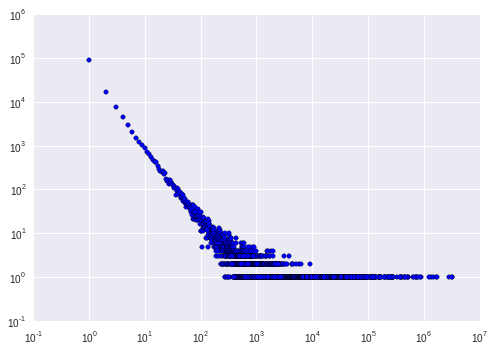

In [108]:
# plot identity distribution, get most frequent identities
identities_counter = Counter()
total_identities = 0
for x in identities:
    identities_counter[x[0]] += x[1]
    total_identities += x[1]
total_identites = float(total_identities)

print 'total identities: ', total_identites#, ' proportion: ', total_identites/total_terms
for x in identities_counter.most_common(25):
    print x[0],  float(x[1])/total_identities
print len(identities_counter)

pdf_data = Counter()
for x in identities_counter.items():
    pdf_data[x[1]] += 1
    
pdf_data = np.array(pdf_data.items())

plt.yscale("log")
plt.xscale('log')
plt.scatter(pdf_data[:,0],pdf_data[:,1])


In [10]:
pdf_dat_df = pd.DataFrame(pdf_data)
pdf_dat_df.to_csv("results/pdf_identities.csv")

In [13]:
# get per-user identities
def get_identities_with_uid_key(line):
    identities = [x[0] for x in get_identities(line)]
    if len(identities):
        uid = dpo.DependencyParseObject(line[0], do_lemmatize=False).dataset
        return  (uid, identities)
    else:
        return [None, []]

per_uid_data = only_identity_tweets.map(get_identities_with_uid_key).reduceByKey(add).collect()
# dump results out to file
msgpack.dump(per_uid_data, open("../analysis/identity_per_user.mpack","wb"))

68.0


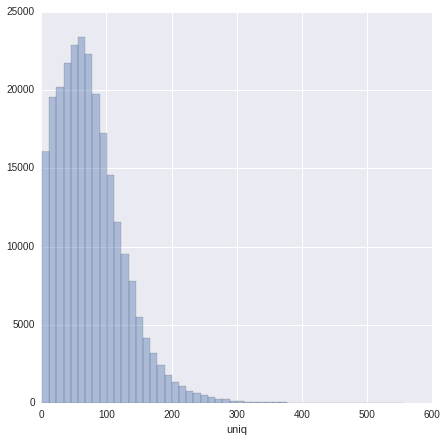

In [15]:
# get some basic stats here for the per user stuff
usage_counts = []
uid_dict = {}
for k, v in per_uid_data:
    uid_dict[k] = v
    usage_counts.append([len(v),len(set(v))])
    
df = pd.DataFrame(usage_counts)
df.columns = ['tot','uniq']
df.sort(columns='uniq',inplace=True,ascending=False)
print df.uniq.median()
df.head(10)

f, ax = plt.subplots(figsize=(7, 7))
#ax.set(xscale="log")
#plt.xlim([1,1000])
sns.distplot(df.uniq,ax=ax,kde=False)

In [18]:
df.to_csv("../python/results/per_user_identity_counts.csv")

In [119]:
# set up the dictionary for the lda 

texts_for_lda = [x[1] for x in per_uid_data if len(set(x[1]))> 50]

print 'n texts: ', len(texts_for_lda)
# run bipartite clustering?
dictionary = corpora.Dictionary(texts_for_lda)
print dictionary
dictionary.filter_extremes(no_below=100)
print dictionary
corpus = [dictionary.doc2bow(text) for text in texts_for_lda]


n texts:  161436
Dictionary(137327 unique tokens: [u'', u'fawn', u'aunt_pol', u'female_child', u'liberal_a-hole']...)
Dictionary(4293 unique tokens: [u'gatekeeper', u'pedophile', u'islander_fan', u'saver', u'vermin']...)


In [ ]:
# run the LDA
lda = models.ldamodel.LdaModel(corpus, num_topics=30, alpha='auto', id2word=dictionary,iterations=1000)
msgpack.dump(top,open("../analysis/lda_mod.mpack","wb"))
lda.save("../analysis/lda_model.lda")

In [ ]:
# save this out for semantic coherence
top = lda.top_topics(corpus,10)
for x in top:
    print x[1],x[0][0][1]

In [14]:
# load cached LDA, write out results

lda = models.ldamodel.LdaModel.load("../analysis/lda_model.lda")

lda_data = []
for i,t in enumerate(lda.show_topics(30, num_words=20, formatted=False)):
    for x in t:
        lda_data.append([i, x[0],x[1]])
        
pd.DataFrame(lda_data).to_csv("../python/results/lda_results.csv")

# Load cached user -> identity matrix
per_uid_data = msgpack.load( open("../analysis/identity_per_user.mpack","rb"))

In [ ]:
# get geotagged data
full_loc_dat = get_loc_data()
geo_tagged_uids = set(full_loc_dat.uid.tolist())

In [21]:
# loc stuff -> transition to nigga part
def get_doc_topic(corpus, model): 
    doc_topic = list() 
    for i,doc in enumerate(corpus): 
        doc_topic.append(model.__getitem__(doc, eps=0)) 
    return doc_topic 

def get_vector_for_topic(top_data, top_num):
    return [x[top_num][1] for x in top_data]

test_for_space  = [dictionary.doc2bow(x[1]) for x in per_uid_data if int(x[0]) in geo_tagged_uids]
test_for_space_uids = [x[0] for x in per_uid_data if int(x[0]) in geo_tagged_uids]
top_data = get_doc_topic(test_for_space,lda)



In [61]:
# do racial comparisons
for topic_num in range(30):
    v_for_n = get_vector_for_topic(top_data,topic_num)
    vn_space = pd.DataFrame(zip(test_for_space_uids,v_for_n))
    vn_space.columns = ['uid','top_'+str(topic_num)+'_val']
    vn_space['uid'] = vn_space.uid.astype(int)
    loc_with_top = pd.merge(loc_with_top,vn_space, left_on='uid',right_on='uid')

In [ ]:
#sns.distplot(loc_with_top.b_percent)
#sns.distplot(loc_with_top.nigga_use)

In [62]:
loc_with_top.to_csv("../python/results/spatial_lda_results.csv")

In [46]:
## now move to affect stuff

def get_tweet_info(line):
    o = dpo.DependencyParseObject(line[0])
    text = " ".join([l.split("\t")[1] for l in line])
    sent = sentiment(text)['compound']
    date = o.is_reply
    identities = get_identities(line)
    return [o.tweet_id, sent,date, [i[0] for i in identities],o.dataset]

#for line in read_grouped_by_newline_file("../analysis/fin_conll_analysis/310325693.txt.gz"):
#    print get_tweet_info(line)
    
tweet_identity_data = only_identity_tweets.map(get_tweet_info)

#tweet_info = tweet_identity_data.collect()
#msgpack.dump(tweet_info,open("../analysis/tweet_info.mpack","wb"))


In [ ]:
# identity usage per 1/4 month
# get the things that modified police, rae identities
# predict user location with per-user prediction

In [ ]:
# Affective

In [49]:
#tweet_info = msgpack.load(open("../analysis/tweet_info.mpack","rb"))
def get_identity_to_person_sent_mat(tweet_info_obj):
    tweet_id, sentiment,date,identities,userid = tweet_info_obj
    if sentiment == 0:
        return []
    else:
        return [ ((i, userid), sentiment) for i in set(identities)]

  
sentiment_mat = tweet_identity_data.flatMap(get_identity_to_person_sent_mat).collect()
msgpack.dump(sentiment_mat,open("../analysis/sentiment_mat.mpack","wb"))


In [ ]:
# get the sentiment matrix, reset 

## NOTE THIS SHOULD REALLY BE SENTIMENT_MAT but bug before when writing out
#sentiment_mat = msgpack.load(open("../analysis/tweet_info.mpack","rb"))
c = Counter()
for i, s in enumerate(sentiment_mat):
    c["_".join(s[0])] += s[1]
    
dat = [x[0].rsplit("_",1)+ [x[1]] for x in c.iteritems()]


In [53]:
# only include the stuff from the lda
lda = models.ldamodel.LdaModel.load("../analysis/lda_model.lda")
per_uid_data = msgpack.load( open("../analysis/identity_per_user.mpack","rb"))
users_for_lda = set([int(x[0]) for x in per_uid_data if len(set(x[1]))> 50])

texts_for_lda = [x[1] for x in per_uid_data if len(set(x[1]))> 50]
print 'n texts: ', len(texts_for_lda)
# run bipartite clustering?
dictionary = corpora.Dictionary(texts_for_lda)
print dictionary
dictionary.filter_extremes(no_below=100)
print dictionary



n texts:  161436
Dictionary(137327 unique tokens: [u'', u'fawn', u'aunt_pol', u'female_child', u'liberal_a-hole']...)
Dictionary(4293 unique tokens: [u'gatekeeper', u'pedophile', u'islander_fan', u'saver', u'vermin']...)


In [54]:
df = pd.DataFrame(dat)
df.columns = ['term','uid','sent']

terms_of_interest = set(dictionary.token2id.keys())
df = df[df.term.apply(lambda x: x in terms_of_interest)]
df['uid'] = df.uid.astype(int)
df = df[df.uid.apply(lambda x: x in users_for_lda)]


UnicodeEncodeError: 'ascii' codec can't encode character u'\xe9' in position 5: ordinal not in range(128)

In [56]:
df.to_csv("../analysis/raw_df.csv",encoding='utf8')

In [114]:
# check out highest and lowest sentiment words
f = df[['term','sent']].groupby("term").sum()
f.sort(columns='sent',inplace=True)
f = f.reset_index()

doc_freq = []
for k in dictionary.token2id.keys():
    doc_freq.append([k, identities_counter[k]])
doc_freq = pd.DataFrame(doc_freq)
doc_freq.columns = ['term','n_doc']
doc_freq.sort(columns='n_doc',ascending=False, inplace=True)
f = pd.merge(f, doc_freq, left_on='term',right_on='term')
f['sent_per_doc'] = f.sent/f.n_doc
f.sort(columns='sent_per_doc',inplace=True)


In [116]:
f.head(10)

,term,sent,n_doc,sent_per_doc
386,bitch_bitch,-100.9976,149,-0.677836
434,hater_nigga,-81.2768,125,-0.650214
332,rape,-132.3976,213,-0.621585
388,white_criminal,-100.6194,176,-0.571701
394,black_criminal,-98.5218,173,-0.569490
185,nigga_bitch,-422.5157,744,-0.567897
199,cop_killer,-375.0204,663,-0.565642
478,animal_abuser,-70.6499,125,-0.565199
216,woman_bitch,-323.1013,592,-0.545779
217,child_abuser,-313.6885,582,-0.538984


In [120]:
z = df.pivot("term","uid","sent").fillna(0)

from sklearn.preprocessing import scale
term_to_u_mat = z.values
term_to_u_mat = scale(term_to_u_mat,1)
term_to_u_mat = scale(term_to_u_mat)

In [122]:
from sklearn.random_projection import SparseRandomProjection
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, FastICA
import sklearn.mixture as mixture

sp = SparseRandomProjection(n_components = 500)
X = sp.fit_transform(term_to_u_mat)
mixed = mixture.VBGMM(n_components=30, covariance_type='diag', n_iter=100)
fitted = mixed.fit(X)


In [123]:
fitted.n_components

30

In [124]:
r = fitted.predict_proba(X)

In [125]:
aff_clust_dat = []
for i in range(r.shape[0]):
    aff_clust_dat.append([z.index[i], r[i].argmax(), r[i].max()])

aff_clust = pd.DataFrame(aff_clust_dat)

In [126]:
aff_clust.columns = ['term','cluster','prob']

In [127]:
aff_clust.sort('prob',inplace=True)

In [130]:
aff_clust.tail(20)

,term,cluster,prob
81,afrikaner,28,0.999997
2549,mistres,28,0.999997
489,bonafide,28,0.999997
3680,spotter,21,0.999997
3037,politico,28,0.999997
3987,underclassman,10,0.999997
2260,liberal_journalist,28,0.999997
1986,immigrant_kid,16,0.999997
2522,miner_daughter,28,0.999997
2519,minded,20,0.999997


In [131]:
aff_clust.to_csv("../python/results/affect_clustering.csv",encoding='utf8')

In [117]:
f.to_csv("../python/results/affect_scores.csv",encoding='utf8')

In [142]:
w2top = {x.strip().split()[0]:x.strip().split()[1] for x in open("results/word2topic.tsv")}

In [224]:
from math import floor
identities_of_interest = {'victim','officer','police_officer','protester',
                          'victim','juror','teen', 'prosecutor',
                          'lawyer','attorney','reporter','journalist','murderer','judge',
                         'nigga','mayor','driver','nigger','negro','racist',"cop","pig",
                         "black","white"}
def get_word_to_date_count(line):
    objs = [dpo.DependencyParseObject(l,do_lemmatize=False) for l in line]
    date = objs[0].is_reply
    uid = objs[0].dataset
    
    if int(date.split("-")[2]) < 13:
        return []

    identities = [o for o in objs if o.label == "Identity"]
    i = 0
    
    ids = []
    heads = []
    
    while i < len(identities):
        text = get_cleaned_text(identities[i].singular_form.lower()).replace("#","")
        head = ''
        if identities[i].head > 0:
            head = objs[identities[i].head-1].text + "_" + objs[identities[i].head-1].postag
        if i < len(identities)-1 and identities[i+1].id == identities[i].id+1:
            tmp_txt = text + "_" + get_cleaned_text(identities[i+1].singular_form.lower()).replace("#","")
            if tmp_txt in identities_of_interest:
                text = tmp_txt
                i+=1
                if identities[i].head > 0:
                    head = objs[identities[i].head-1].text + "_" + objs[identities[i].head-1].postag   
        ids.append(text)
        heads.append(head)
        
        i +=1
        
        
    if not len(set(ids) & identities_of_interest):
        return []
    
    head2 = []
    for h in heads:
        try:
            h.encode('ascii')
            head2.append(h)
        except:
            head2.append('')
    
    text = " ".join([l.split("\t")[1] for l in line])
    sent = sentiment(text)['compound']
    d_spl = date.split("-")
    wk = int(floor(float(d_spl[1]) / 15))
    if wk > 1:
        wk = 1
    day = str((wk * 15)+1)
    date_ret = "-".join([d_spl[0],day,d_spl[2]])
    return [ (date_ret, x, head2[i], sent, uid) for i,x in enumerate(ids) if x in identities_of_interest]


# for x in read_grouped_by_newline_file(all_files[40]):
#     z =  get_word_to_date_count(x)
#     if len(z):
#         print '\t', z
date_info = only_identity_tweets.flatMap(get_word_to_date_count).collect()


In [ ]:
tweet_i

In [178]:
full_loc_dat = get_loc_data()
geo_tagged_uids = set([int(x) for x in full_loc_dat.uid.tolist()])

n geotagged users:  73040


In [235]:
date_info[1]

(u'09-16-14', u'victim', u'cry_V', -0.8176, u'636262914')

In [192]:
from collections import Counter, defaultdict
blah = defaultdict(lambda: defaultdict(Counter))
z = defaultdict(lambda:defaultdict(Counter))
for x in date_info:
    blah[x[3]][x[1]][x[0]] += x[2]
    z[x[3]][x[1]][x[0]] += 1
    
time_dat = []
for user,word_date_count in blah.items():
    for word, date_count in word_date_count.items():
        for date, count in date_count.items():
            date_split = date.split("-")
            year = date_split[2]
            month = date_split[0]
            day = int(date_split[1])
            if day > 1:
                day = 1
            day = str(day * 15)
            time_dat.append([user,word,"-".join([month,day,year]),count,z[user][word][date]])

time_df = pd.DataFrame(time_dat)
time_df.to_csv("../python/results/time_sent_user_df.csv")

In [234]:
pdf_data[:,1].sum()

143428

In [ ]:
# ck how affective meanings change
